# Latent Diffusion

WIP implementation of latent diffusion from the paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752). The autoencoder is a vector-quantized variational autoencoder from the paper [Neural Discrete Representation Learning](https://arxiv.org/abs/1711.00937).

Resources Used:
- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
- [Variational AutoEncoder](https://keras.io/examples/generative/vae/)
- [Vector-Quantized Variational Autoencoders](https://keras.io/examples/generative/vq_vae/)
- [Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/)

In [2]:
import tensorflow as tf
from keras import layers
import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import tensorflow_datasets as tfds
from keras.preprocessing.image import ImageDataGenerator

In [3]:
image_size = 128
channels = 3

# Autoencoder.
dropout = 0.1
autoencoder_batch_size = 256
autoencoder_widths = [16, 8, 8]
autoencoder_block_depth = 3
latent_size = int(image_size / 2**len(autoencoder_widths))
beta_slope = 0.002
beta_period = 1000

# Diffusion.
diffusion_batch_size = 2048
min_signal_rate = 0.02
max_signal_rate = 0.95
embedding_dims = 32
embedding_max_frequency = 1000.0
diffusion_widths = [32, 64, 96]
diffusion_block_depth = 2

In [525]:
def preprocessing_function(image):
    image = image.astype(float) / 255
    return image

idg = ImageDataGenerator(preprocessing_function = preprocessing_function)
dogs = idg.flow_from_directory(
    '../stanford_dogs/images/Images/', 
    target_size = (image_size, image_size), 
    batch_size = autoencoder_batch_size,
    color_mode = 'rgb',
    classes = ['']
)

Found 20580 images belonging to 1 classes.


In [526]:
def plot_images(images):
    plt.figure(figsize = (50 * 3, 50))
    num_images = images.shape[0]
    
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])

    plt.tight_layout()
    plt.show()

## VQ VAE

In [24]:
embedding_dim = 16
num_embeddings = 20
embeddings = tf.random.normal(shape=(num_embeddings, embedding_dim))
x = tf.random.normal(shape=(32, 32, 16))
x = tf.reshape(x, (-1, embedding_dim))
print(x.shape)
diffs = tf.stack([x - embedding for embedding in embeddings])
sizes = tf.reduce_sum(diffs**2, axis=2)**0.5
indices = tf.math.argmin(sizes, axis=0)

for i in range(20):
    pass
    #print(indices[i])
    
z = tf.gather(embeddings, indices.numpy())
z = tf.reshape(z, (32, 32, 16))
#print(z.shape)

(1024, 16)


In [104]:
class VectorQuantiser(layers.Layer):
    def __init__(self, embedding_dim, num_embeddings,**kwargs):
        super().__init__(**kwargs)
        
        self.embedding_dim = embedding_dim
        self.num_embeddings = num_embeddings
        self.embeddings = tf.Variable(
            tf.random.normal((num_embeddings, embedding_dim)),
            trainable=True
        )
    
    def call(self, z):
        w, h, c = z.shape[1:]
        z = tf.reshape(z, (w*h, embedding_dim))
        similarity = tf.matmul(z, self.embeddings, transpose_b=True)
        distances = (
            tf.reduce_sum(z**2, axis=1, keepdims=True)
            + tf.reduce_sum(self.embeddings**2, axis=1)
            - 2 * similarity
        )
        indices = tf.argmin(distances, axis=1)
        encodings = tf.one_hot(indices, self.num_embeddings)
        quantized = tf.matmul(encodings, self.embeddings, transpose_b=True)
        print(encodings.shape)
        #z = tf.stack([z - embedding for embedding in self.embeddings])
        #z = tf.reduce_sum(z**2, axis=2)**0.5
        #indices = tf.math.argmin(z, axis=0).numpy()
        #z = tf.gather(self.embeddings, indices)
        #z = tf.reshape(z, (w, h, c))
        return z

In [105]:
x = layers.Input((32, 32, 16))
x = VectorQuantiser(embedding_dim = 16, num_embeddings = 10)(x)
x.shape

(1024, 10)
Tensor("vector_quantiser_42/strided_slice:0", shape=(10,), dtype=float32)


TensorShape([1024, 16])

## Variational Autoencoder

In [527]:
def EncoderBlock(widths):
    def apply(x):
        for width in widths:
            if x.shape[0] == width:
                residual = x
            else:
                residual = layers.Conv2D(width, (1, 1))(x)
            x = layers.BatchNormalization()(x)
            for _ in range(autoencoder_block_depth):
                x = layers.Conv2D(width, (3, 3), activation='relu', padding='same')(x)
            x = layers.Add()([x, residual])
            x = layers.MaxPooling2D((2, 2), padding='same')(x)
        return x
    
    return apply

def DecoderBlock(widths):
    def apply(x):
        for width in widths:
            if x.shape[0] == width:
                residual = x
            else:
                residual = layers.Conv2D(width, (1, 1))(x)
            for _ in range(autoencoder_block_depth):
                x = layers.Conv2D(width, (3, 3), activation='relu', padding='same')(x)
            x = layers.Add()([x, residual])
            x = layers.UpSampling2D((2, 2))(x)
            
        x = layers.Conv2D(channels, (3, 3), activation='sigmoid', padding='same')(x)
        return x
    
    return apply

class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=(z_mean.shape[1], z_mean.shape[2], channels))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [528]:
class VAE(keras.Model):
    def __init__(self, widths, beta_slope, beta_period, encoder=None, decoder=None):
        super().__init__()
        self.encoder_widths = widths
        self.decoder_widths = list(reversed(widths))
        
        if encoder != None:
            self.encoder = encoder
        else:
            self.encoder = self.create_encoder()
            
        if decoder != None:
            self.decoder = decoder
        else:
            self.decoder = self.create_decoder()
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        
        self.beta_schedule_step = 0
        self.beta = 0
        self.beta_slope = beta_slope
        self.beta_period = beta_period
    
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def create_encoder(self):
        input_image = layers.Input(shape=(image_size, image_size, channels))
        x = EncoderBlock(self.encoder_widths)(input_image)
        z_mean = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z_log_var = layers.Conv2D(channels, (2, 2), padding='same')(x)
        z = Sampling()([z_mean, z_log_var])
        return keras.Model(input_image, [z_mean, z_log_var, z])
    
    def create_decoder(self):
        input_latent = layers.Input(shape=(latent_size, latent_size, channels))
        decoded = DecoderBlock(self.decoder_widths)(input_latent)
        return keras.Model(input_latent, decoded)
    
    def train_step(self, data):
        data = data[0] # Get rid of labels.
        self.beta_schedule_step += 1
        
        with tf.GradientTape() as tape:
            # Encoding/Decoding.
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            # loss.
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            
            if(self.beta_schedule_step == self.beta_period):
                self.beta = 0
                self.beta_schedule_step = 0
            if self.beta < 1:
                self.beta = self.beta_slope * self.beta_schedule_step
            else:
                self.beta = 1.0
                
            kl_loss = -self.beta * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def encode(self, data):
        _, _, z = self.encoder(data)
        return z
    
    def decode(self, data):
        x = self.decoder(data)
        return x

In [529]:
vae = VAE(autoencoder_widths, beta_slope, beta_period)
vae.compile(optimizer='adam')

In [530]:
vae.fit(dogs, epochs=1000)

Epoch 1/1000
81/81 [==============================] - 23s 246ms/step - loss: 10776.7319 - reconstruction_loss: 10100.0869 - kl_loss: 0.2468
Epoch 2/1000
81/81 [==============================] - 21s 254ms/step - loss: 9370.2521 - reconstruction_loss: 9319.2832 - kl_loss: 0.7017
Epoch 3/1000
81/81 [==============================] - 21s 263ms/step - loss: 9244.9448 - reconstruction_loss: 9220.4961 - kl_loss: 0.8592
Epoch 4/1000
81/81 [==============================] - 21s 255ms/step - loss: 9186.3597 - reconstruction_loss: 9173.0918 - kl_loss: 0.9741
Epoch 5/1000
81/81 [==============================] - 21s 254ms/step - loss: 9146.6222 - reconstruction_loss: 9146.3730 - kl_loss: 1.0917
Epoch 6/1000
81/81 [==============================] - 21s 253ms/step - loss: 9135.9805 - reconstruction_loss: 9135.2520 - kl_loss: 1.1006
Epoch 7/1000
81/81 [==============================] - 21s 260ms/step - loss: 9131.9170 - reconstruction_loss: 9119.1016 - kl_loss: 1.1420
Epoch 8/1000
81/81 [============

Epoch 60/1000
81/81 [==============================] - 20s 241ms/step - loss: 8995.2028 - reconstruction_loss: 8994.8828 - kl_loss: 1.1625
Epoch 61/1000
81/81 [==============================] - 20s 242ms/step - loss: 9005.5687 - reconstruction_loss: 8993.1670 - kl_loss: 1.1290
Epoch 62/1000
81/81 [==============================] - 20s 243ms/step - loss: 8994.1907 - reconstruction_loss: 8991.3457 - kl_loss: 1.1368
Epoch 63/1000
81/81 [==============================] - 20s 245ms/step - loss: 8989.6924 - reconstruction_loss: 8989.2676 - kl_loss: 1.1626
Epoch 64/1000
81/81 [==============================] - 20s 245ms/step - loss: 9019.3649 - reconstruction_loss: 8994.2246 - kl_loss: 1.1409
Epoch 65/1000
81/81 [==============================] - 20s 245ms/step - loss: 8980.8782 - reconstruction_loss: 8990.1777 - kl_loss: 1.1334
Epoch 66/1000
81/81 [==============================] - 20s 244ms/step - loss: 8987.9532 - reconstruction_loss: 8989.8477 - kl_loss: 1.1317
Epoch 67/1000
81/81 [======

81/81 [==============================] - 20s 241ms/step - loss: 8954.6542 - reconstruction_loss: 8963.8252 - kl_loss: 0.8244
Epoch 177/1000
81/81 [==============================] - 20s 245ms/step - loss: 8971.4082 - reconstruction_loss: 8962.5762 - kl_loss: 0.8253
Epoch 178/1000
81/81 [==============================] - 20s 242ms/step - loss: 8963.3079 - reconstruction_loss: 8964.2812 - kl_loss: 0.8214
Epoch 179/1000
81/81 [==============================] - 20s 241ms/step - loss: 8957.9959 - reconstruction_loss: 8963.3359 - kl_loss: 0.8207
Epoch 180/1000
81/81 [==============================] - 20s 243ms/step - loss: 8963.4282 - reconstruction_loss: 8963.8857 - kl_loss: 0.8216
Epoch 181/1000
81/81 [==============================] - 20s 243ms/step - loss: 8967.2247 - reconstruction_loss: 8962.1338 - kl_loss: 0.8222
Epoch 182/1000
81/81 [==============================] - 20s 246ms/step - loss: 8941.7044 - reconstruction_loss: 8961.4268 - kl_loss: 0.8200
Epoch 183/1000
81/81 [=============

81/81 [==============================] - 20s 243ms/step - loss: 8972.8851 - reconstruction_loss: 8955.0400 - kl_loss: 0.7611
Epoch 293/1000
81/81 [==============================] - 20s 243ms/step - loss: 8947.7185 - reconstruction_loss: 8954.1123 - kl_loss: 0.7610
Epoch 294/1000
81/81 [==============================] - 20s 248ms/step - loss: 8964.0459 - reconstruction_loss: 8954.6426 - kl_loss: 0.7593
Epoch 295/1000
81/81 [==============================] - 20s 246ms/step - loss: 8933.7293 - reconstruction_loss: 8953.3105 - kl_loss: 0.7573
Epoch 296/1000
81/81 [==============================] - 20s 244ms/step - loss: 8948.3713 - reconstruction_loss: 8953.5527 - kl_loss: 0.7599
Epoch 297/1000
81/81 [==============================] - 20s 243ms/step - loss: 8968.6739 - reconstruction_loss: 8954.2773 - kl_loss: 0.7576
Epoch 298/1000
81/81 [==============================] - 21s 257ms/step - loss: 8963.5736 - reconstruction_loss: 8955.0791 - kl_loss: 0.7563
Epoch 299/1000
81/81 [=============

81/81 [==============================] - 20s 242ms/step - loss: 8943.2752 - reconstruction_loss: 8949.8096 - kl_loss: 0.7344
Epoch 409/1000
81/81 [==============================] - 19s 239ms/step - loss: 8963.3001 - reconstruction_loss: 8948.7119 - kl_loss: 0.7325
Epoch 410/1000
81/81 [==============================] - 20s 242ms/step - loss: 8957.6782 - reconstruction_loss: 8950.4580 - kl_loss: 0.7340
Epoch 411/1000
81/81 [==============================] - 20s 244ms/step - loss: 8961.3345 - reconstruction_loss: 8948.8506 - kl_loss: 0.7338
Epoch 412/1000
81/81 [==============================] - 20s 242ms/step - loss: 8937.6230 - reconstruction_loss: 8950.0547 - kl_loss: 0.7330
Epoch 413/1000
81/81 [==============================] - 20s 243ms/step - loss: 8951.2710 - reconstruction_loss: 8951.2041 - kl_loss: 0.7316
Epoch 414/1000
81/81 [==============================] - 20s 241ms/step - loss: 8949.4490 - reconstruction_loss: 8951.0459 - kl_loss: 0.7311
Epoch 415/1000
81/81 [=============

81/81 [==============================] - 20s 242ms/step - loss: 8949.5830 - reconstruction_loss: 8947.3086 - kl_loss: 0.7185
Epoch 525/1000
81/81 [==============================] - 20s 239ms/step - loss: 8944.6699 - reconstruction_loss: 8947.3516 - kl_loss: 0.7178
Epoch 526/1000
81/81 [==============================] - 20s 242ms/step - loss: 8954.7322 - reconstruction_loss: 8947.2324 - kl_loss: 0.7188
Epoch 527/1000
81/81 [==============================] - 20s 242ms/step - loss: 8950.5161 - reconstruction_loss: 8947.2188 - kl_loss: 0.7180
Epoch 528/1000
81/81 [==============================] - 20s 241ms/step - loss: 8951.1307 - reconstruction_loss: 8947.1787 - kl_loss: 0.7186
Epoch 529/1000
81/81 [==============================] - 20s 241ms/step - loss: 8954.7286 - reconstruction_loss: 8947.7324 - kl_loss: 0.7173
Epoch 530/1000
81/81 [==============================] - 19s 239ms/step - loss: 8952.9302 - reconstruction_loss: 8946.0303 - kl_loss: 0.7187
Epoch 531/1000
81/81 [=============

81/81 [==============================] - 20s 243ms/step - loss: 8942.1714 - reconstruction_loss: 8945.5127 - kl_loss: 0.7094
Epoch 641/1000
81/81 [==============================] - 20s 243ms/step - loss: 8938.5406 - reconstruction_loss: 8946.0449 - kl_loss: 0.7084
Epoch 642/1000
81/81 [==============================] - 20s 241ms/step - loss: 8943.1998 - reconstruction_loss: 8944.8535 - kl_loss: 0.7078
Epoch 643/1000
81/81 [==============================] - 20s 242ms/step - loss: 8952.9741 - reconstruction_loss: 8944.0713 - kl_loss: 0.7086
Epoch 644/1000
81/81 [==============================] - 20s 242ms/step - loss: 8952.9599 - reconstruction_loss: 8945.7188 - kl_loss: 0.7085
Epoch 645/1000
81/81 [==============================] - 20s 242ms/step - loss: 8943.8765 - reconstruction_loss: 8943.3760 - kl_loss: 0.7088
Epoch 646/1000
81/81 [==============================] - 20s 242ms/step - loss: 8943.5188 - reconstruction_loss: 8945.9434 - kl_loss: 0.7060
Epoch 647/1000
81/81 [=============

81/81 [==============================] - 20s 241ms/step - loss: 8959.1654 - reconstruction_loss: 8944.7373 - kl_loss: 0.7018
Epoch 757/1000
81/81 [==============================] - 20s 240ms/step - loss: 8927.3754 - reconstruction_loss: 8941.9102 - kl_loss: 0.7020
Epoch 758/1000
81/81 [==============================] - 20s 241ms/step - loss: 8949.0543 - reconstruction_loss: 8943.2295 - kl_loss: 0.7011
Epoch 759/1000
81/81 [==============================] - 20s 242ms/step - loss: 8940.3263 - reconstruction_loss: 8944.1855 - kl_loss: 0.7012
Epoch 760/1000
81/81 [==============================] - 22s 266ms/step - loss: 8942.7073 - reconstruction_loss: 8943.1895 - kl_loss: 0.7024
Epoch 761/1000
81/81 [==============================] - 20s 239ms/step - loss: 8945.2538 - reconstruction_loss: 8942.3193 - kl_loss: 0.7008
Epoch 762/1000
81/81 [==============================] - 20s 240ms/step - loss: 8950.0473 - reconstruction_loss: 8946.0244 - kl_loss: 0.7013
Epoch 763/1000
81/81 [=============

81/81 [==============================] - 20s 246ms/step - loss: 8941.6429 - reconstruction_loss: 8942.9170 - kl_loss: 0.6985
Epoch 873/1000
81/81 [==============================] - 20s 243ms/step - loss: 8935.9911 - reconstruction_loss: 8942.0566 - kl_loss: 0.6987
Epoch 874/1000
81/81 [==============================] - 20s 246ms/step - loss: 8945.6740 - reconstruction_loss: 8942.3496 - kl_loss: 0.6990
Epoch 875/1000
81/81 [==============================] - 20s 244ms/step - loss: 8925.3223 - reconstruction_loss: 8943.2373 - kl_loss: 0.7001
Epoch 876/1000
81/81 [==============================] - 20s 243ms/step - loss: 8951.0562 - reconstruction_loss: 8942.1426 - kl_loss: 0.6981
Epoch 877/1000
81/81 [==============================] - 20s 241ms/step - loss: 8939.2904 - reconstruction_loss: 8941.1064 - kl_loss: 0.6997
Epoch 878/1000
81/81 [==============================] - 20s 242ms/step - loss: 8933.7403 - reconstruction_loss: 8941.1201 - kl_loss: 0.6995
Epoch 879/1000
81/81 [=============

81/81 [==============================] - 20s 242ms/step - loss: 8946.8484 - reconstruction_loss: 8939.1885 - kl_loss: 0.6985
Epoch 989/1000
81/81 [==============================] - 20s 242ms/step - loss: 8931.8182 - reconstruction_loss: 8940.9766 - kl_loss: 0.6973
Epoch 990/1000
81/81 [==============================] - 20s 244ms/step - loss: 8940.8352 - reconstruction_loss: 8940.6934 - kl_loss: 0.6976
Epoch 991/1000
81/81 [==============================] - 20s 245ms/step - loss: 8949.2251 - reconstruction_loss: 8940.0986 - kl_loss: 0.6963
Epoch 992/1000
81/81 [==============================] - 20s 241ms/step - loss: 8931.7857 - reconstruction_loss: 8941.6523 - kl_loss: 0.6961
Epoch 993/1000
81/81 [==============================] - 20s 243ms/step - loss: 8935.5938 - reconstruction_loss: 8940.3779 - kl_loss: 0.6960
Epoch 994/1000
81/81 [==============================] - 20s 241ms/step - loss: 8945.0855 - reconstruction_loss: 8939.9971 - kl_loss: 0.6958
Epoch 995/1000
81/81 [=============

In [ ]:
vae.encoder.save('data/encoder10')
vae.decoder.save('data/decoder10')

In [531]:
dogs.reset()
encoded_images = vae.encode(dogs.next()[0])

for i in range(dogs.__len__()):
    next_encoded = vae.encode(dogs.next()[0])
    encoded_images = tf.concat([encoded_images, next_encoded], axis=0)

decoded_images = vae.decode(encoded_images[0 : 10])

Encoded:


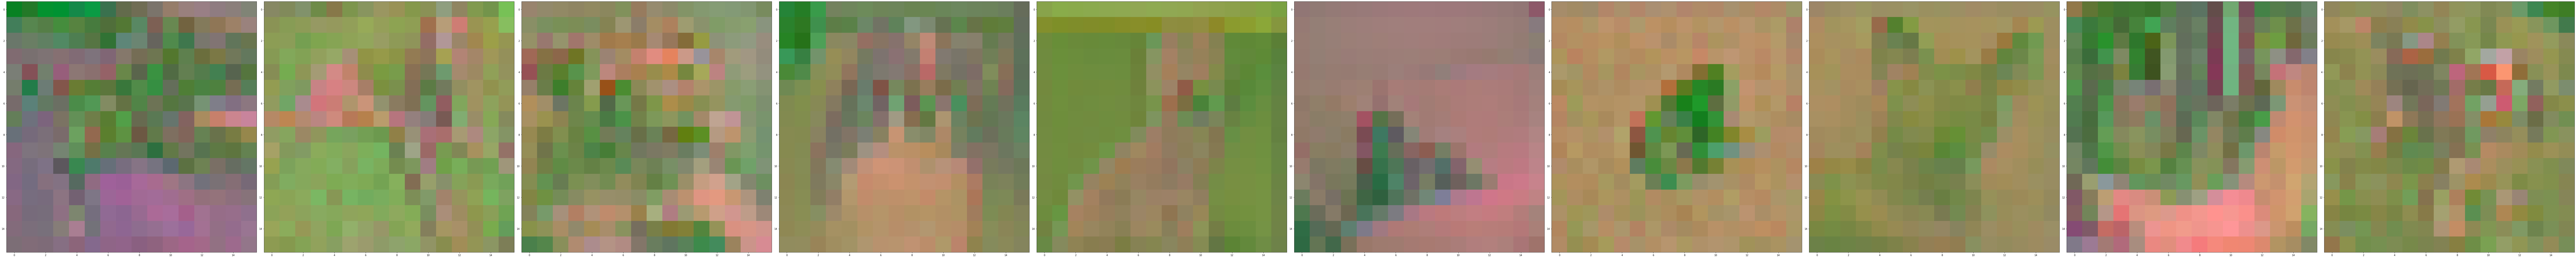

Decoded:


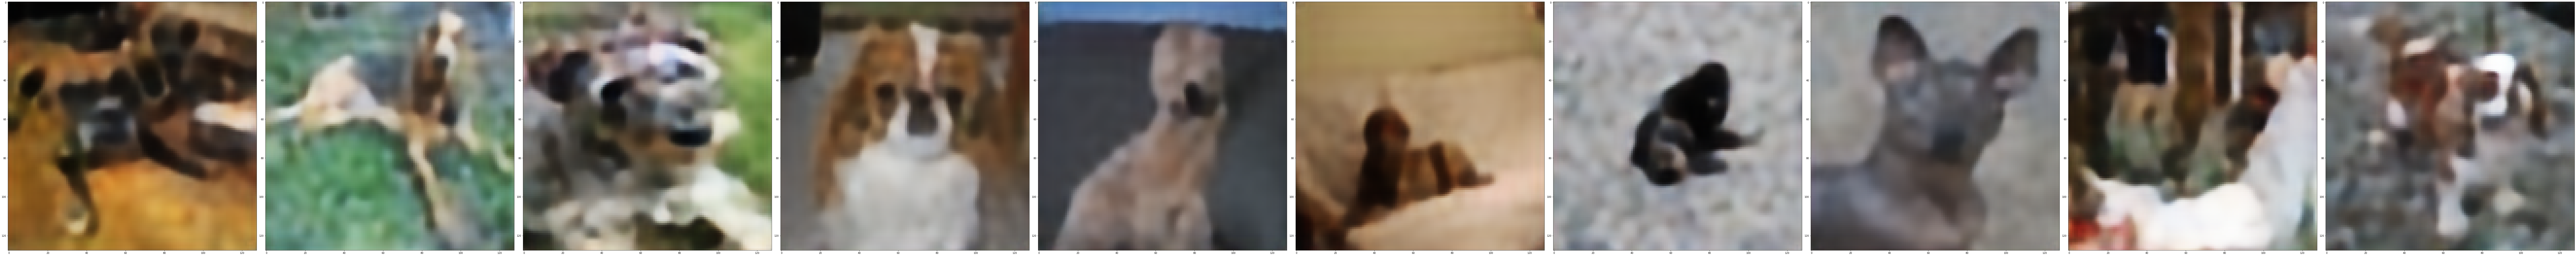

In [532]:
print('Encoded:')
encoded_display = encoded_images[0:10].numpy()
encoded_display -= np.min(encoded_display)
encoded_display /= np.max(encoded_display)
plot_images(encoded_display)

print('Decoded:')
decoded_images = vae.decode(encoded_images[0 : 10])
plot_images(decoded_images.numpy())

Encoded:


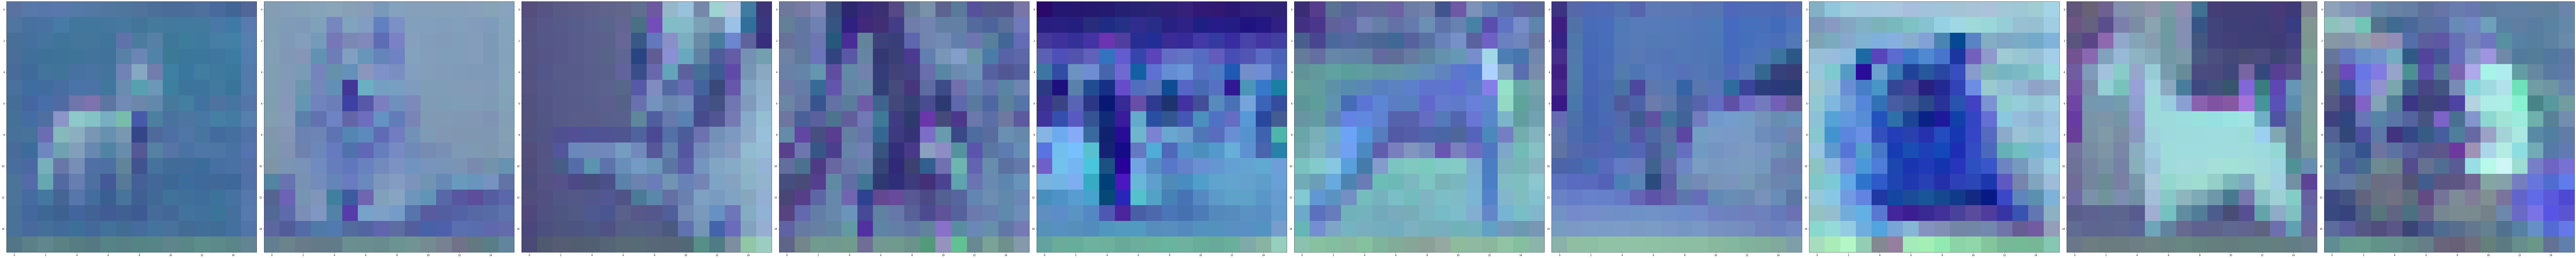

Decoded:


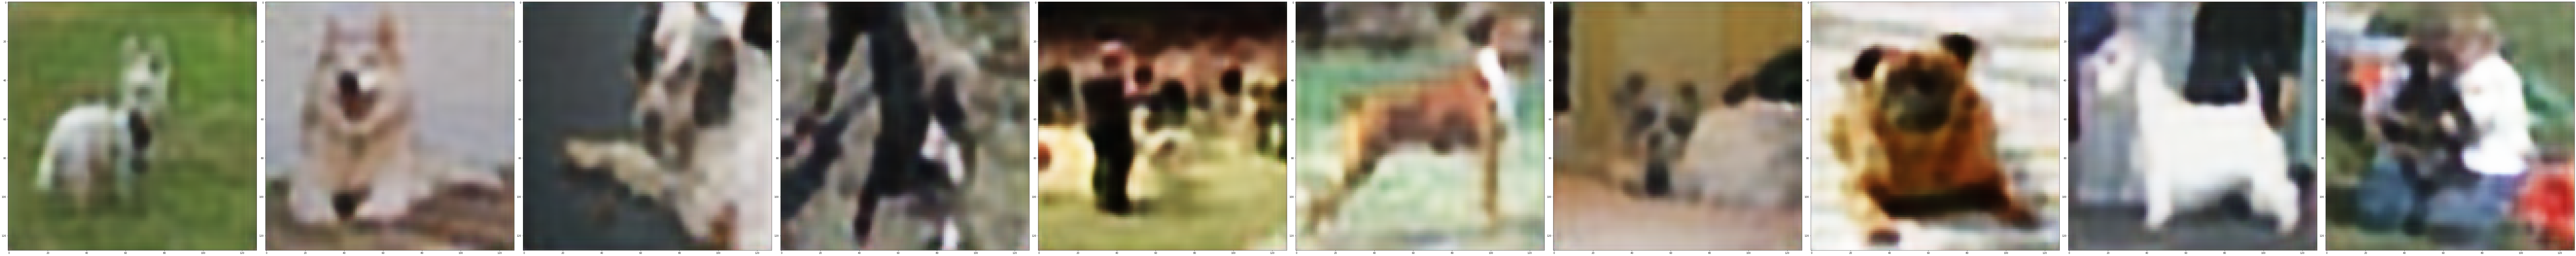

In [510]:
print('Encoded:')
encoded_display = encoded_images[0:10].numpy()
encoded_display -= np.min(encoded_display)
encoded_display /= np.max(encoded_display)
plot_images(encoded_display)

print('Decoded:')
decoded_images = vae.decode(encoded_images[0 : 10])
plot_images(decoded_images.numpy())

## Denoising U-Net

In [222]:
def sinusoidal_embedding(x):
    embedding_min_frequency = 1.0
    frequencies = tf.exp(tf.linspace(tf.math.log(embedding_min_frequency),
                         tf.math.log(embedding_max_frequency),
                         embedding_dims // 2))
    angular_speeds = 2.0 * math.pi * frequencies
    embeddings = tf.concat([tf.sin(angular_speeds * x), tf.cos(angular_speeds * x)], axis=3)
    return embeddings

def ResidualBlock(width):
    def apply(x):
        input_width = x.shape[3]
        if input_width == width:
            residual = x
        else:
            residual = layers.Conv2D(width, kernel_size=1)(x)
        x = layers.BatchNormalization(center=False, scale=False)(x)
        x = layers.Conv2D(
            width, kernel_size=3, padding="same", activation=keras.activations.swish
        )(x)
        x = layers.Conv2D(width, kernel_size=3, padding="same")(x)
        x = layers.Add()([x, residual])
        return x

    return apply

def DownBlock(width, block_depth):
    def apply(x):
        x, skips = x
        for _ in range(block_depth):
            x = ResidualBlock(width)(x)
            skips.append(x)
        x = layers.AveragePooling2D(pool_size=2)(x)
        return x

    return apply

def UpBlock(width, block_depth):
    def apply(x):
        x, skips = x
        x = layers.UpSampling2D(size=2, interpolation="bilinear")(x)
        for _ in range(block_depth):
            x = layers.Concatenate()([x, skips.pop()])
            x = ResidualBlock(width)(x)
        return x

    return apply

In [460]:
class DiffusionModel(keras.Model):
    def __init__(self, input_size, block_depth, widths):
        super().__init__()
        
        self.normalizer = layers.Normalization()
        self.model = self.create_model(input_size, widths, block_depth)
        self.input_size = input_size
    
    def create_model(self, input_size, widths, block_depth):
        noisy_input = keras.Input(shape=(input_size, input_size, channels))
        noise_variances = keras.Input(shape=(1, 1, 1))
        
        e = layers.Lambda(sinusoidal_embedding)(noise_variances)
        e = layers.UpSampling2D(size=input_size, interpolation='nearest')(e)
        
        x = layers.Conv2D(widths[0], kernel_size=1)(noisy_input)
        x = layers.Concatenate()([x, e])
        
        skips = []
        for width in widths[:-1]:
            x = DownBlock(width, block_depth)([x, skips])
            
        for _ in range(block_depth):
            x = ResidualBlock(widths[-1])(x)
        
        for width in reversed(widths[:-1]):
            x = UpBlock(width, block_depth)([x, skips])
            
        x = layers.Conv2D(channels, kernel_size=1, kernel_initializer='zeros')(x)
        
        return keras.Model([noisy_input, noise_variances], x)
    
    def compile(self, **kwargs):
        super().compile(**kwargs)
        
        self.noise_loss_tracker = keras.metrics.Mean(name='n_loss')
        self.image_loss_tracker = keras.metrics.Mean(name='i_loss')
    
    @property
    def metrics(self):
        return [self.noise_loss_tracker, self.image_loss_tracker]
    
    def diffusion_schedule(self, diffusion_times):
        start_angle = tf.acos(max_signal_rate)
        end_angle = tf.acos(min_signal_rate)

        diffusion_angles = start_angle + diffusion_times * (end_angle - start_angle)

        signal_rates = tf.cos(diffusion_angles)
        noise_rates = tf.sin(diffusion_angles)

        return noise_rates, signal_rates
    
    def denoise(self, noisy_images, noise_rates, signal_rates, training):
        pred_noises = self.model([noisy_images, noise_rates**2], training=training)
        pred_images = (noisy_images - noise_rates * pred_noises) / signal_rates
        
        return pred_noises, pred_images
    
    def reverse_diffusion(self, initial_noise, diffusion_steps):
        num_images = initial_noise.shape[0]    
        step_size = 1.0 / diffusion_steps
        
        next_noisy_images = initial_noise
        for step in range(diffusion_steps):
            noisy_images = next_noisy_images
            
            diffusion_times = tf.ones((num_images, 1, 1, 1)) - step * step_size
            noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=False
            )
            
            next_diffusion_times = diffusion_times - step_size
            next_noise_rates, next_signal_rates = self.diffusion_schedule(
                next_diffusion_times
            )
            next_noisy_images = (
                next_signal_rates * pred_images + next_noise_rates * pred_noises
            )
            
        return pred_images
    
    def generate(self, num_images, diffusion_steps):
        initial_noise = tf.random.normal(shape=(num_images, self.input_size, self.input_size, channels))
        generated_images = self.reverse_diffusion(initial_noise, diffusion_steps)
        return generated_images
    
    def train_step(self, images):
        #images = self.normalizer(images, training=True)
        noises = tf.random.normal(shape=(diffusion_batch_size, self.input_size, self.input_size, channels))
        
        diffusion_times = tf.random.uniform(
            shape=(diffusion_batch_size, 1, 1, 1), minval=0.0, maxval=1.0
        )
        
        noise_rates, signal_rates = self.diffusion_schedule(diffusion_times)
        noisy_images = signal_rates * images + noise_rates * noises
        
        with tf.GradientTape() as tape:
            pred_noises, pred_images = self.denoise(
                noisy_images, noise_rates, signal_rates, training=True
            )
            
            noise_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(noises, pred_noises), axis=(1, 2)
                )
            )
            
            image_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(images, pred_images), axis=(1, 2)
                )
            )
            
        grads = tape.gradient(noise_loss, self.model.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_weights))

        self.noise_loss_tracker.update_state(noise_loss)
        self.image_loss_tracker.update_state(image_loss)
            
        return {m.name: m.result() for m in self.metrics}

In [546]:
end_index = int(encoded_images.shape[0] / diffusion_batch_size) * diffusion_batch_size
encoded_images = encoded_images[:end_index]

In [547]:
model = DiffusionModel(latent_size, diffusion_block_depth, diffusion_widths)
model.compile(optimizer='adam')

In [548]:
model.fit(encoded_images, epochs=100, batch_size=diffusion_batch_size)

Epoch 1/100
10/10 [==============================] - 3s 131ms/step - n_loss: 222.4115 - i_loss: 8317.2852
Epoch 2/100
10/10 [==============================] - 1s 130ms/step - n_loss: 112.5793 - i_loss: 3202.4282
Epoch 3/100
10/10 [==============================] - 1s 130ms/step - n_loss: 63.3105 - i_loss: 1143.8126
Epoch 4/100
10/10 [==============================] - 1s 133ms/step - n_loss: 50.2083 - i_loss: 757.8698
Epoch 5/100
10/10 [==============================] - 1s 130ms/step - n_loss: 45.2313 - i_loss: 510.3284
Epoch 6/100
10/10 [==============================] - 1s 131ms/step - n_loss: 42.6580 - i_loss: 369.6393
Epoch 7/100
10/10 [==============================] - 1s 130ms/step - n_loss: 41.3376 - i_loss: 287.1530
Epoch 8/100
10/10 [==============================] - 1s 131ms/step - n_loss: 39.5886 - i_loss: 252.7456
Epoch 9/100
10/10 [==============================] - 1s 133ms/step - n_loss: 38.4658 - i_loss: 206.3048
Epoch 10/100
10/10 [==============================] - 1s 13

Encoded:


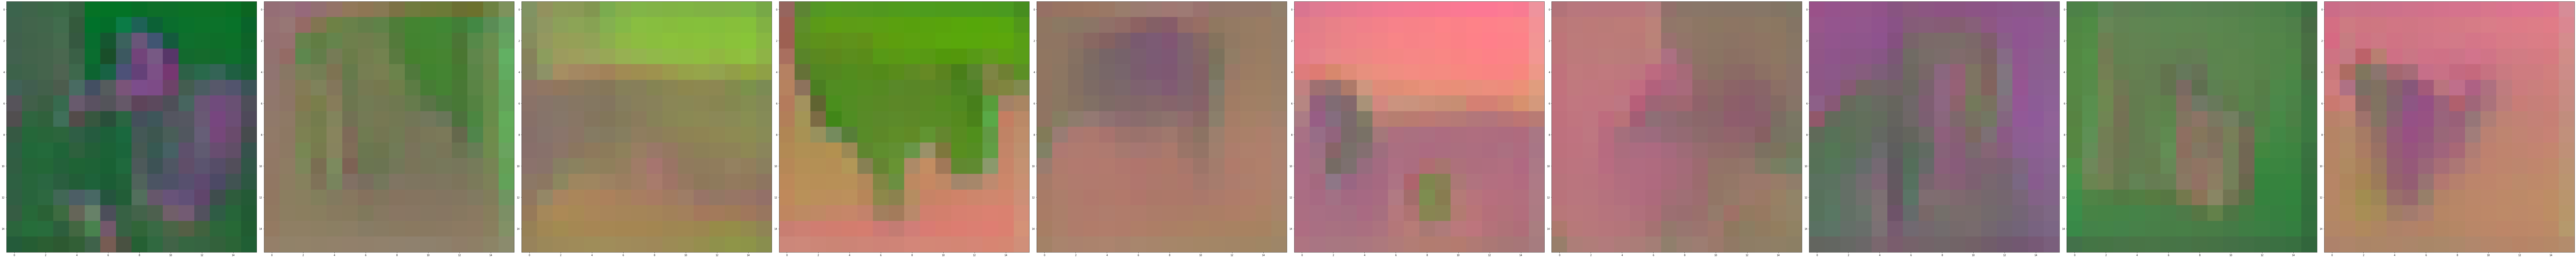

Decoded:


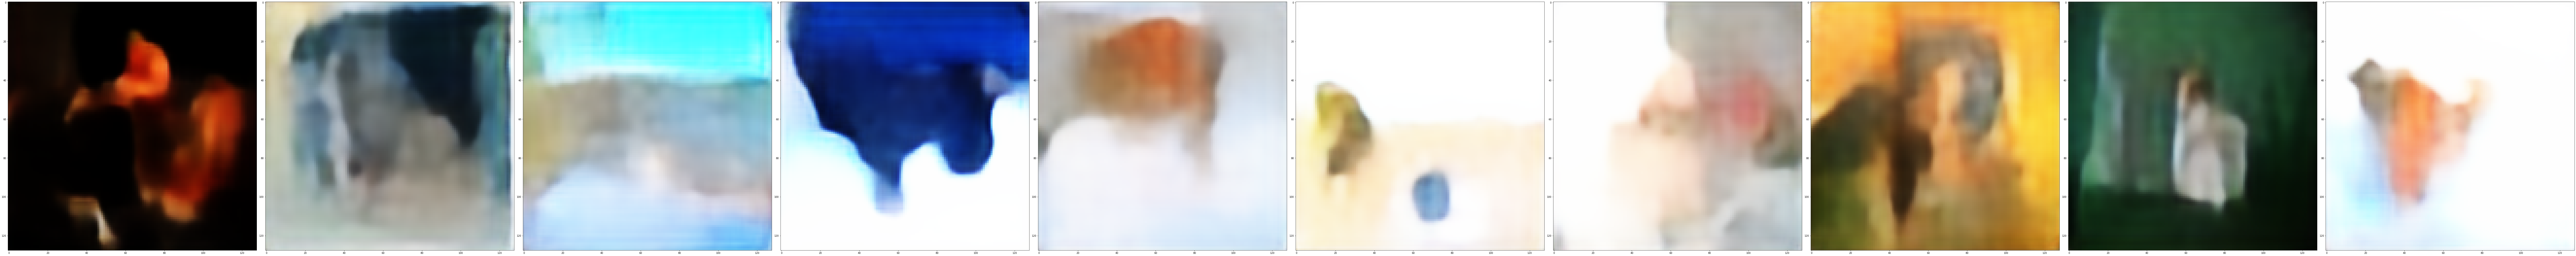

In [543]:
print('Encoded:')
generated_latents = model.generate(10, 20)
display_latents = generated_latents.numpy()
display_latents -= np.min(display_latents)
display_latents /= np.max(display_latents)
plot_images(display_latents)

print('Decoded:')
generated_images = vae.decode(generated_latents)
plot_images(generated_images.numpy())

In [310]:
unet.save('../latent_diffusion_unet3')

INFO:tensorflow:Assets written to: ../latent_diffusion_unet3\assets


INFO:tensorflow:Assets written to: ../latent_diffusion_unet3\assets
